**Краевая задача Дирихле для уравнения Пуассона в двумерной области:**

$\left\{
\begin{aligned}
&\Delta u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} =3 \sin\left(\frac{5\pi x}{3}\right) \sin\left(\frac{2\pi y}{3}\right) + 4 \sin\left(\frac{3\pi x}{3}\right) \sin\left(\frac{5\pi y}{3}\right), \quad 0 < x < 3, \quad 0 < y < 3 \\
&u(0, y) = 5 \sin\left(\frac{2\pi y}{3}\right), \quad 0 \le y \le 3 \\
&u(3, y) = 3 \sin\left(\frac{5\pi y}{3}\right), \quad 0 \le y \le 3 \\
&u(x, 0) = 0, \quad 0 \le x \le 3 \\
&u(x, 3) = 0, \quad 0 \le x \le 3 \\
\end{aligned}
\right.$

**Аналитическое решение:**

Предположим, что решение можно представить в виде $u(x, y) = X(x)Y(y)$   
Подставим в уравнение Пуассона и получим две задачи Штурма-Лиувилля  
Решив ОДУ второго порядка с учетом граничных условий, получим собственные значения и функции, тем самым определим вид частного решения  
Решение однородной задачи является суммой частных решений, где коэффициенты находятся из граничных условий  
С учетом ортогональности синусоидальных функций получим, что в ряде останутся только слагаемые, отвечающие функциям в граничных условиях  
Далее, например, методом вариации постоянной найдем частное решение  
Решение исходной задачи является суммой общего решения однородного уравнения и частного решения неоднородного

Проделав эти математические выкладки, получим аналитическое решение:

$u(x, y) = 5 \sin\left(\frac{2\pi y}{3}\right) \frac{\sinh\left(\frac{2\pi (3 - x)}{3}\right)}{\sinh(2\pi)} + 3 \sin\left(\frac{5\pi y}{3}\right) \frac{\sinh\left(\frac{5\pi x}{3}\right)}{\sinh(5\pi)} - \frac{27}{29\pi^2} \sin\left(\frac{5\pi x}{3}\right) \sin\left(\frac{2\pi y}{3}\right) - \frac{36}{34\pi^2} \sin\left(\pi x\right) \sin\left(\frac{5\pi y}{3}\right)$

**Численное решение:**

Выполним дискретизацию уравнения, заменив производные разностными отношениями на сетке  
Для решения системы применим БПФ по $y$, переходя в частотное пространство  
В частотном пространстве решаем трехдиагональные СЛАУ относительно $x$ методом прогонки  
После возвращаемся в исходное пространство и учитываем граничные условия для получения итогового численного решения

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Размеры области
l_x = 3
l_y = 3

# Количество точек сетки
N_x = 2 ** 9
N_y = 2 ** 9

# Граничные условия
phi_1 = lambda y: 5 * np.sin(2 * np.pi * y / l_y)
phi_2 = lambda y: 3 * np.sin(5 * np.pi * y / l_y)

# Функция источника
f = lambda x, y: -3 * np.sin(5 * np.pi * x / l_x) * np.sin(2 * np.pi * y / l_y) - 4 * np.sin(3 * np.pi * x / l_x) * np.sin(5 * np.pi * y / l_y)

# Аналитическое решение
u = lambda x, y: (
    5 * np.sin(2 * np.pi * y / l_y) * np.sinh(2 * np.pi * (l_x - x) / l_y) / np.sinh(2 * np.pi * l_x / l_y) +
    3 * np.sin(5 * np.pi * y / l_y) * np.sinh(5 * np.pi * x / l_y) / np.sinh(5 * np.pi * l_x / l_y) -
    (3 / ((25 * np.pi**2) / (l_x**2) + (4 * np.pi**2) / (l_y**2))) * np.sin(5 * np.pi * x / l_x) * np.sin(2 * np.pi * y / l_y) -
    (4 / ((9 * np.pi**2) / (l_x**2) + (25 * np.pi**2) / (l_y**2))) * np.sin(3 * np.pi * x / l_x) * np.sin(5 * np.pi * y / l_y)
)

In [ ]:
def tridiagonal_matrix_algorithm(N, A, B, C, F, hi_1, mu_1, hi_2, mu_2):
    a = np.zeros(N)
    b = np.zeros(N)
    y = np.zeros(N + 1)

    a[0] = hi_1
    b[0] = mu_1

    for i in range(N - 1):
        d = C[i] - A[i] * a[i]
        a[i + 1] = B[i] / d
        b[i + 1] = (F[i] + A[i] * b[i]) / d

    y[N] = (mu_2 + hi_2 * b[N - 1]) / (1 - hi_2 * a[N - 1])

    for i in range(N - 1, -1, -1):
        y[i] = a[i] * y[i + 1] + b[i]

    return y

In [ ]:
def bit_reverse_indices(N):
    n_bits = int(np.log2(N))
    reversed_indices = np.zeros(N, dtype=int)

    for i in range(N):
        reversed_indices[i] = int(f"{i:0{n_bits}b}"[::-1], 2)

    return reversed_indices

def fft_iterative(x):
    N = len(x)

    # Битово-реверсивная перестановка
    x = np.array(x, dtype=complex)[bit_reverse_indices(N)]

    # Основной цикл БПФ
    for s in range(1, int(np.log2(N)) + 1):  # Итерации по уровням преобразования
        m = 1 << s  # Размер подпоследовательности (2^s)
        w_m = np.exp(-2j * np.pi / m)  # Поворотный множитель

        # Обработка всех подпоследовательностей текущего уровня
        for k in range(0, N, m):
            w = 1
            half_m = m // 2

            for j in range(half_m):
                # Индексы элементов для текущей операции
                idx_even = k + j
                idx_odd = k + j + half_m

                # Бабочка
                even = x[idx_even]
                odd = w * x[idx_odd]

                # Обновление значений
                x[idx_even] = even + odd
                x[idx_odd] = even - odd
                w *= w_m

    return x

def fft(f):
    f = np.pad(f, (1, N_y))
    return np.sqrt(2 / l_y) * fft_iterative(f)[1 : N_y].imag

In [ ]:
def solve(l_x, l_y, N_x, N_y, phi_1, phi_2, f):
    # Сетка
    h_x = l_x / N_x
    h_y = l_y / N_y
    x = np.linspace(h_x, l_x - h_x, N_x - 1)
    y = np.linspace(h_y, l_y - h_y, N_y - 1)
    Y, X = np.meshgrid(x, y)

    # Применение БПФ к правой части и граничным условиям
    f_fft = h_y * np.apply_along_axis(fft, 1, f(X, Y))
    phi_1_fft = h_y * fft(phi_1(y))
    phi_2_fft = h_y * fft(phi_2(y))

    # Прогонка
    u_fft = np.zeros((N_x + 1, N_y - 1))
    A = np.ones(N_x - 1)
    B = np.ones(N_x - 1)

    for k in range(0, N_y - 1):
        C = np.full(N_x - 1, 2 + (2 / h_y * np.sin(np.pi*(k + 1)/(2 * N_y))) ** 2 * h_x**2)
        u_fft[:, k] = tridiagonal_matrix_algorithm(N_x, A, B, C, h_x**2 * f_fft[:, k], 0, phi_1_fft[k], 0, phi_2_fft[k])

    u = np.apply_along_axis(fft, 1, u_fft)

    # Граничные условия и выравнивание размерности для исходной сетки
    return np.pad(u, ((0, 0), (1, 1)), mode='constant')

In [ ]:
x = np.linspace(0, l_x, N_x + 1)
y = np.linspace(0, l_y, N_y + 1)
Y, X = np.meshgrid(x, y)

analytical_sol = u(X, Y)
numerical_sol = solve(l_x, l_y, N_x, N_y, phi_1, phi_2, f)

Максимальная абсолютная погрешность: 8.736166490219688e-05


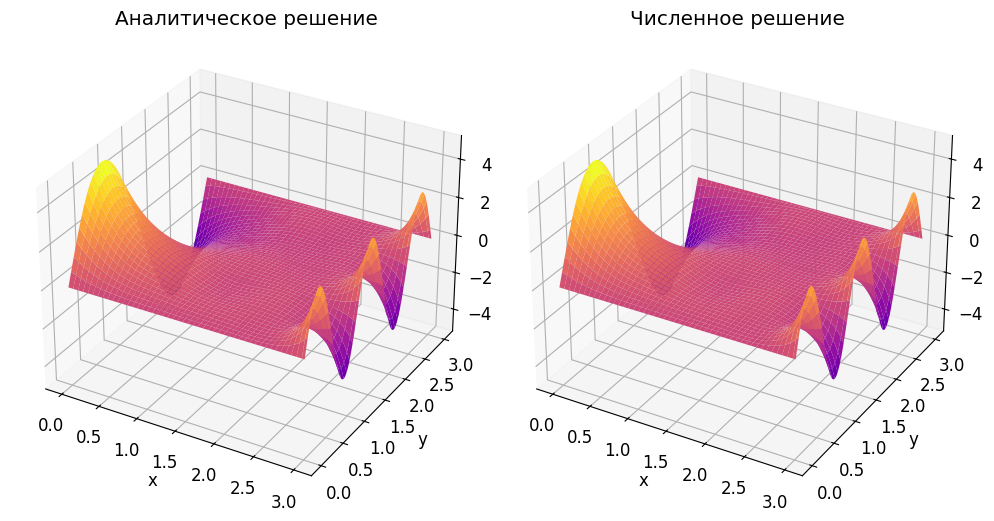

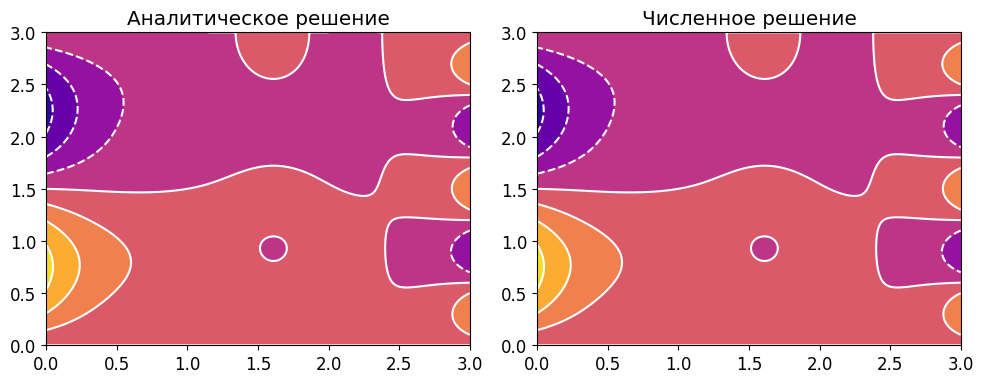

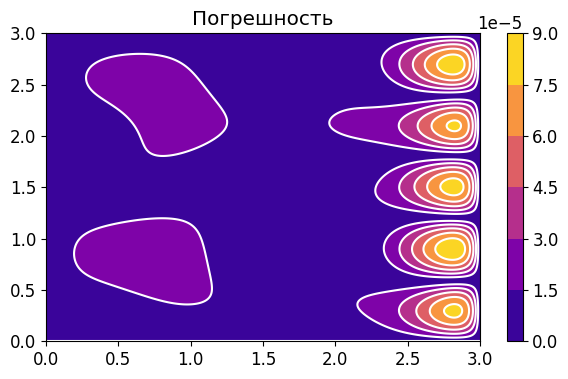

In [ ]:
print("Максимальная абсолютная погрешность:", np.max(np.abs(analytical_sol - numerical_sol)))

plt.rcParams['font.size'] = 12

# --- 3D-графики ---
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(X, Y, analytical_sol, cmap='plasma')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.set_title("Аналитическое решение")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_surface(X, Y, numerical_sol, cmap='plasma')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')
ax2.set_title("Численное решение")
plt.tight_layout()
plt.show()

# --- Линии уровня ---
fig = plt.figure(figsize=(10, 4))
ax3 = fig.add_subplot(121)
ax3.contourf(X, Y, analytical_sol, cmap='plasma')
ax3.contour(X, Y, analytical_sol, colors='white')
ax3.set_title("Аналитическое решение")

ax4 = fig.add_subplot(122)
ax4.contourf(X, Y, numerical_sol, cmap='plasma')
ax4.contour(X, Y, numerical_sol, colors='white')
ax4.set_title("Численное решение")
plt.tight_layout()
plt.show()

# --- Погрешность ---
diff = np.abs(analytical_sol - numerical_sol)
plt.figure(figsize=(7, 4))
im_diff = plt.contourf(X, Y, diff, cmap='plasma')
plt.contour(X, Y, diff, colors='white')
plt.title("Погрешность")
cbar_diff = plt.colorbar(im_diff)
plt.show()

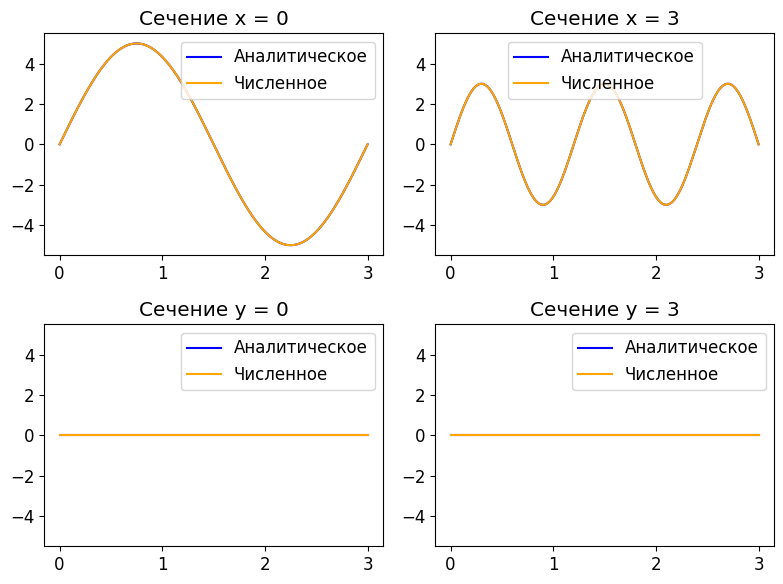

In [ ]:
# --- Сечения ---
const_x_vals = [0, l_x]
const_y_vals = [0, l_y]
ymin, ymax = -5.5, 5.5

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

for i, const_x in enumerate(const_x_vals):
    idx = np.argmin(np.abs(x - const_x))
    axs[0, i].plot(y, analytical_sol[idx, :], label='Аналитическое', color='blue')
    axs[0, i].plot(y, numerical_sol[idx, :], label='Численное', color='orange')
    axs[0, i].legend()
    axs[0, i].set_title(f"Сечение x = {const_x}")
    axs[0, i].set_ylim(ymin, ymax)

for i, const_y in enumerate(const_y_vals):
    idx = np.argmin(np.abs(y - const_y))
    axs[1, i].plot(x, analytical_sol[:, idx], label='Аналитическое', color='blue')
    axs[1, i].plot(x, numerical_sol[:, idx], label='Численное', color='orange')
    axs[1, i].legend()
    axs[1, i].set_title(f"Сечение y = {const_y}")
    axs[1, i].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()